# Gridded data analysis

In this demo, we will be investigating the extent of **shrubification** in Alaska using the **National Land Cover Database (NLCD)**. "Shrubification" describes the expansion of shrubs across the **Arctic**. Shrubs are woody plants with diverse growth forms but are often the tallest plants occupying tundra ecosystems and can form dense thickets with closed canopies in suitable habitats. 

Studies indicate that warming temperatures, changes in snow cover, altered disturbance regimes (due to permafrost thaw, tundra fires, anthropogenic activities or changes in herbivory intensity) are all contributing to general **increases in shrub abundance** which will have wide-ranging consequences for the ecosystems and climate of the region (e.g. soil, permafrost, caribou).

```{image} images/shrubs.jpeg
:width: 600px
:align: center
```

## National Land Cover Database

The National Land Cover Database (NLCD) provides **gridded land cover** at a 30 m resolution with a **20-class legend (in Alaska)** based on a modified Anderson Level II classification system. 

The database is designed to provide cyclical updates of United States land cover every 2-3 years since 2001. 

Enables systematic documententation of land cover change for monitoring and trend assessments.

```{image} images/nlcd-classes.jpg
:width: 300px
:align: center
```

## Gridded data

Gridded (or raster) data represent a matrix of cells (or pixels) organized into rows and columns (or a grid). Grid cells can represent data that changes **continuously** across a landscape (surface) such as elevation, air temperature, or reflectance data from satellite imaging platforms. Grid cells can also represent **discrete** data such as vegetation type or land cover.

```{image} images/raster-matrix.png
:width: 500px
:align: center
```

## Libraries

The main library for accessing and analyzing gridded data in Python is called `rasterio` which builds on the popular **Geographic Raster Abstraction Library** or **GDAL**. It supports read/write access for over 160 gridded data formats (e.g. GeoTIFF, NetCDF4) and includes methods for finding dataset information, reprojecting, resampling, format conversion, and mosaicking. 

```{image} images/gdal.png
:width: 200px
:align: center
```

Let's get started...

In [ ]:
# Import libraries
import numpy as np
import rasterio
import pandas as pd
import matplotlib.pyplot as plt

## Open dataset

The data is formatted as a GeoTIFF (`.tif`) file which is one of the many formats that can be read by `rasterio`. We can open the dataset using the function `open()` which accepts a **path string** and returns a **dataset object**.

```{note}
The data for this demo can be accessed [here](https://www.dropbox.com/sh/czfmie4piindv8n/AAAiZCdIoi9dSqVTIHK0c8yPa?dl=0).
```

````{margin}
```{note}
`src` stands for **source**
```
````

In [ ]:
src = rasterio.open('data/nlcd_2016_ak.tif')
src

## Dataset attributes

The **dataset object** contains a number of **attributes** which can be explored using the following methods. Remember that a raster **band** is an array of values representing **a single** variable in 2D space. All bands of a dataset have the **same** number of rows and columns.

In [ ]:
print(f"Number of bands: {src.count}")
print(f"Width: {src.width}")
print(f"Height: {src.height}")
print(f"Data type: {src.dtypes}")

## Georeferencing

Like vector data, pixels in raster data can be mapped to regions on the Earth's surface. Like `GeoPandas`, we can display the **coordinate reference system** of our data using the `crs` method. 

In [ ]:
src.crs

The output from this function can be a little overwelming but there is some useful information contained here. For example it looks like the data are projected using an [**Albers projection system**](https://en.wikipedia.org/wiki/Albers_projection) and the units are in **meters**. 

We can display some more specific information about a dataset's projection using the `transform` method. This function returns the **spatial resolution** of the dataset (i.e. the dimensions that each pixel of our dataset represents on the ground) and the coordinates of the **top left** corner.

In [ ]:
src.transform

Alternatively, we can display the bounding box of our dataset using the `bounds()` method.

In [ ]:
src.bounds

## Reading raster data

Now that we have some basic information, we can go ahead and import our data as a NumPy **N-D array** using the `read()` function. Data from each band can be accessed by an index number. 

```{note}
Note that bands are indexed from 1 due to a  GDAL convention. 
```

In [ ]:
nlcd_2016 = src.read(1)
nlcd_2016

In [ ]:
type(nlcd_2016)

## Plot data

We can have a look at the data using `matplotlib`. Since the dataset is so big (eight billion pixels!), we will just plot a subset of the data.

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
im = ax.imshow(nlcd_2016, cmap='tab20b')
ax.set_title("Alaska land cover in 2016", fontsize=12)

## Single land cover type

It would be useful to identify what some of these colors mean. To do this we can use **matrix indexing** to find the value of a pixel at a given location (i.e. `array[row, column]`). In this case we find the land cover at **y (or row) = 500** and **x (or column) = 3000**. 

In [ ]:
nlcd_2016[500, 3000]

The land cover type is **52** meaning **shrub/scrub**. 

```{image} images/nlcd-shrubs.png
:width: 800px
:align: center
```

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
im = ax.imshow(nlcd_2016, cmap='tab20b')
ax.scatter(3000, 500, s=100, color='k')
ax.set_title("Alaska land cover in 2016", fontsize=12)

## Frequency of land cover type

Clearly shrubs (class 52) cover a large portion the land cover in this region of Alaska. To **quantify** how much area they cover, it would be useful to count the **occurrence of each land cover class**. We can do that using NumPy's [`unique()`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) function, making sure we set `return_counts` to `True`. 

In [ ]:
unique, counts = np.unique(nlcd_2016, return_counts=True)
dict(zip(unique, counts))

In [ ]:
# Count number of land pixels
land_pixels = nlcd_2016.size

# Convert to DataFrame
df_2016 = pd.DataFrame(list(zip(unique, counts, (counts/land_pixels)*100)), 
                       columns=['lc', 'count_2016', 'fraction_2016'])
df_2016

This is very useful. With reference to the NLCD land cover classes, our table shows that the most dominant type of land cover is **dwarf shrub** (51) at **22%** althoug **normal shrubs** (52) are not far behind with **17%**. We also have some **evergreen forest** (42) at **13%** and **woody wetlands** (90) at **10%**. 

```{image} images/nlcd-classes.jpg
:width: 300px
:align: center
```

## Aggregate land cover classes

Since we are interested in all kinds of shrubs, we will combine the the **dwarf shrubs** and **shrub/scrub** classes. The most simple way of doing this is to re-assign all grid cells classified as **shrub/scrub** (52) to **dwarf shrubs** (51) using a **mask**.

In [ ]:
# Re-assign land cover class
nlcd_2016[nlcd_2016 == 52] = 51

In [ ]:
# Check there are no more grid cells classified as normal shrubs
unique, counts = np.unique(nlcd_2016, return_counts=True)

# Convert to DataFrame
df_2016 = pd.DataFrame(list(zip(unique, counts, (counts/land_pixels)*100)), 
                       columns=['lc', 'count_2016', 'fraction_2016'])
df_2016

## Land cover change

The big question here is have these shrubs always occupied a large portion of this region of Alaska? To answer that we could perform the same analysis on a previous NLCD dataset from 2001.

In [ ]:
# Open
src_2001 = rasterio.open('data/nlcd_2001_ak.tif')

# Read
nlcd_2001 = src_2001.read(1)

# Re-assign land cover class
nlcd_2001[nlcd_2001 == 52] = 51

In [ ]:
# Count occurrence in each class
unique, counts = np.unique(nlcd_2001, return_counts=True)

# Convert to DataFrame
df_2001 = pd.DataFrame(list(zip(unique, counts, (counts/land_pixels)*100)),
                       columns=['lc', 'count_2001', 'fraction_2001'])
df_2001

Combining the DataFrames should allow us to compute the difference between 2001 and 2016

In [ ]:
df = pd.merge(df_2001, df_2016, on=['lc'])
df

In [ ]:
df['change'] = (df['count_2016'] - df['count_2001'])
df['change_percent'] = (((df['count_2016'] - df['count_2001']) / df['count_2001']) * 100)
df

## Shrubification?

Oh dear - the extent of shrubs did **not** increase between 2001 and 2016. One takeaway from this could be that shrubification is **not happening** in this region of the Arctic. But the percentage change in shrubs was very small (-0.02%), well below what we would expect the uncertainty to be in our land cover product. 

Other, perhaps more significant changes, that occurred between 2001 and 2016 include an increase in **deciduous forest** (41) by **3.9%**, a decrease in **evergreen forest** (42) by **0.4%**, and a decrease in **emergent herbaceous wetlands** (95) by **0.4%**. 

## Direction of land cover change

It would be interesting to know **how** grid cells changed between 2001 and 2016. We can do this by **masking** the 2016 land cover data with specific grid cells from the 2001 land cover data. For example, in the code below we identify grid cells in 2016 that were classified as **evergreen forest** (class 42) in 2001. We then compute what land cover they are by **masking the 2016 land cover data** and using the `unique()` function.

In [ ]:
mask = nlcd_2016[nlcd_2001 == 42]
unique, counts = np.unique(mask, return_counts=True)

In [ ]:
forestchange_df = pd.DataFrame(list(zip(unique, counts, (counts/mask.shape[0])*100)),
                 columns=['lc', 'count', 'fraction'])
forestchange_df

It looks like most of the **evergreen forest** (99.6%) did not change between 2001 and 2016. When it did, it was most likely to change to **shrub** (51). Let's finish this section by plotting a map showing where **evergreen forest** was replaced by **shrub**.

In [ ]:
forest2shrub = (nlcd_2001 == 42) & ((nlcd_2016 == 51))

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(forest2shrub.astype(int), cmap='Blues')
ax.set_title("Forest to shrubs in Alaska between 2001 and 2016", fontsize=12)

At this scale, it's difficult to see what's going on. Let's zoom in a little...

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
im2 = ax.imshow(forest2shrub.astype(int)[1000:1750,2750:3750], cmap='Blues')
ax.set_title("Forest to shrubs in Alaska between 2001 and 2016", fontsize=12)

## Neigborhood operations

So far, we have focused on **local operations**, treating individual grid cells as independent observations that are not influenced by each other. In reality, the land cover of a given grid cell is likely to be similar to adjacent grid cells, than distance grid cells. 

**Tobler's First Law of Geography** is a fundamental principle of spatial analysis that says, 

> Everything is related to everything else, but near things are more related than distant things

We can exploit this concept using neigborhood operations. For example, let's say our land cover dataset contained missing values or outliers. We could easily identify (and replace) these values by comparing them against the values of surrounding grid cells. A **median filter** is a common approach for outlier filtering. 

```{image} images/median-filter.png
:width: 700px
:align: center
```

The `scipy.ndimage` package provides many functions for applying these neighborhood operations. We define window size (also termed **kernel**) using the `size` parameter and the function automatically slides (or **convolves**) this window across our entire grid. 

```{image} images/window.png
:width: 500px
:align: center
```

```{note}
We chose a large window size to demonstrate the `median_filter` output - `size=15` would be 15 x 15 pixels or a 450 x 450 m window. 
```

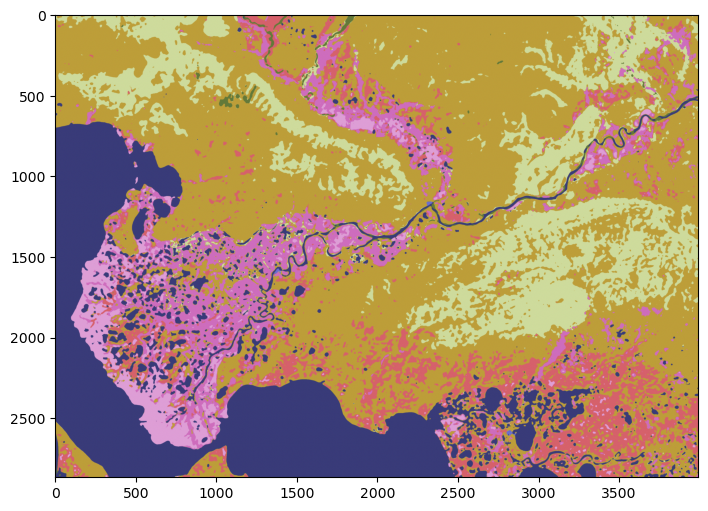

In [44]:
from scipy.ndimage import median_filter

# Apply 9x9 median filter
nlcd_2001_median = median_filter(nlcd_2001, size=15)

# Plot
fig, ax = plt.subplots(figsize=(12,6))
im = ax.imshow(nlcd_2001_median, cmap='tab20b')

The median filter reduces the difference between a grid cell and surrounding grid cells. These type of filters are therefore called **low-pass filters**. 

```{note}
We could use any window size or shape. Likewise, there is almost no limit to the different operations we could apply to grid cell values in our window.
```

A 3×3 Gaussian kernel with sigma=1 provides a weighted mean of neigboring values and can be defined as:

$$
G = \frac{1}{16}
\begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{bmatrix}
$$


In contrast, a **high-pass filter** emphasizes differences between a grid cell and its neighbors. The classic one is a Laplacian filter:

$$
H =
\begin{bmatrix}
0 & -1 & 0 \\
-1 &  4 & -1 \\
0 & -1 & 0
\end{bmatrix}
$$

And `NumPy` and `SciPy` make the linear algebra straightforward.

Since our land cover classes are not continuous values, it doesn't make sense to apply a Gaussian and Laplacian filter to our data. But we would implement it using `generic_filter` that applies a specific function to each element.

```python
# Define a 3x3 Gaussian kernel (σ=1)
gaussian_kernel = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
], dtype=float)

# Normalize
gaussian_kernel = gaussian_kernel / gaussian_kernel.sum()

# Define function for generic_filter
def gaussian_filter_func(window):
    window = window.reshape((3, 3))
    return np.sum(window * gaussian_kernel)

# Apply filter
smoothed = ndimage.generic_filter(image, function=gaussian_filter_func, size=3)
```

Let's demonstrate one more time, this time using a custom **diversity index** that simply counts the number of unique land covers in each 15 x 15 window.

In [46]:
from scipy.ndimage import generic_filter

def diversity_metric(window):
    values = window.astype(int)
    unique = np.unique(values[values > 0])
    return len(unique)

div_map = generic_filter(nlcd_2001, diversity_metric, size=15)

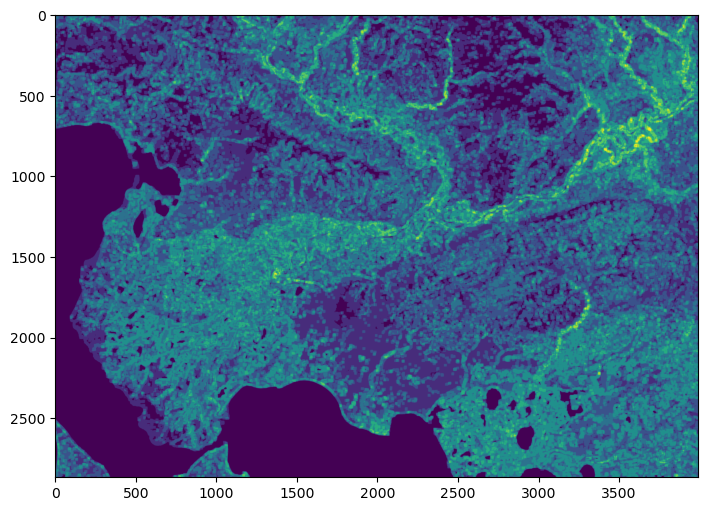

In [48]:
# Plot
fig, ax = plt.subplots(figsize=(12,6))
im = ax.imshow(div_map)